Study ini ditujukan untuk memprediksi apakah aplikan kredit akan mengalami masalah kredit macet sehingga dengan menggunakan study ini perbankan bisa menseleksi aplikan dengan lebih akurat untuk meminimalisir Non-Performing-Loan (NPL). Study ini menggunakan Artificial Intelligence dengan algoritma `Logistic Regression`, `RandomForestClassifier`, dan `Neural Network`.

## Preparation

In [0]:
from google.colab import drive
drive.mount('/content/yudaprama')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/yudaprama


In [0]:
import os
os.chdir('/content/yudaprama/My Drive/ai-instant-loan-approval')
!ls

data				 ai-instant-loan-approval.ipynb
model.py			 __pycache__
processing.py			 computing.py


In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from utils import  split_data

In [0]:
# Load data files
application_data = pd.read_csv('data/application_train.csv')
bureau_data = pd.read_csv('data/bureau_train.csv')

## Data Cleaning and Processing

In [0]:
application_data.head()

,ID,TARGET,LOAN_TYPE,GENDER,OWN_CAR,OWN_REALTY,CNT_CHILDREN,INCOME_TOTAL,CREDIT,ANNUITY,...,DOCUMENT_18,DOCUMENT_19,DOCUMENT_20,DOCUMENT_21,REQ_CREDIT_BUREAU_HOUR,REQ_CREDIT_BUREAU_DAY,REQ_CREDIT_BUREAU_WEEK,REQ_CREDIT_BUREAU_MON,REQ_CREDIT_BUREAU_QRT,REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
bureau_data.head()

,ID,ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,CREDIT_SUM,CREDIT_SUM_DEBT,CREDIT_SUM_LIMIT,CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Hanya 1 column yang identik antara 2 data files, yaitu *ID*. 

In [0]:
application_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, ID to REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [0]:
# Finding target variable counts in the data
application_data['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

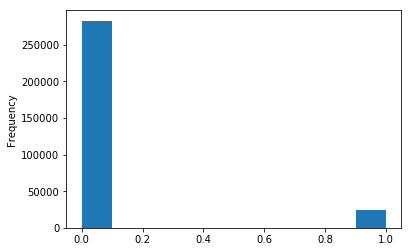

In [0]:
# Plotting histogram from target variable
application_data['TARGET'].astype(int).plot('hist')
plt.show()

Explore missing values pada data

In [0]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe memiliki " + str(df.shape[1]) + " columns.\n"      
            "" + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        return mis_val_table_ren_columns

In [0]:
missing_values = missing_values_table(application_data)
missing_values.head(20)

Dataframe memiliki 122 columns.
67 columns that have missing values.


Encode column dengan categorical variables.

In [0]:
le = LabelEncoder()
le_count = 0

# Iterasi through the columns
for col in application_data:
    if application_data[col].dtype == 'object':
        if len(list(application_data[col].unique())) <= 2:
            le.fit(application_data[col])
            application_data[col] = le.transform(application_data[col])            
            le_count += 1
            
print('%d label column telah diencoded.' % le_count)

3 label column telah diencoded.

Exploring the data more and finding out some anomalies. 

In [0]:
(application_data['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [0]:
application_data['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

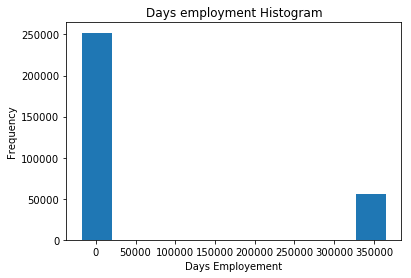

In [0]:
application_data['DAYS_EMPLOYED'].plot.hist(title='Days employment Histogram')
plt.xlabel('Days Employement')
plt.show()

In [0]:
anom = application_data[application_data['DAYS_EMPLOYED'] == 365243]
non_anom = application_data[application_data['DAYS_EMPLOYED'] != 365243]
print('Non-anomalies on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('Anomalies on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('%d anomalous days of employment' % len(anom))

Non-anomalies on 8.66% of loans
Anomalies on 5.40% of loans
55374 anomalous days of employment


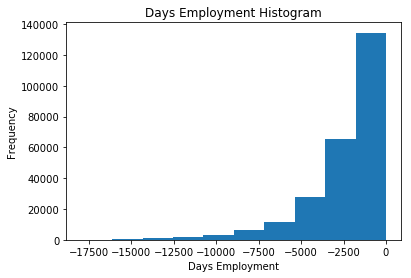

In [0]:
# Create anomalous column with flag
application_data['DAYS_EMPLOYED_ANOM'] = application_data["DAYS_EMPLOYED"] == 365243

# Replace anomalous values with NAN
application_data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

application_data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')
plt.show()

In [0]:
application_data = pd.get_dummies(application_data)

In [0]:
bureau_data = pd.get_dummies(bureau_data)

In [0]:
print("Shape of application data", application_data.shape)
print("Shape of bureau data", bureau_data.shape)

Shape of application data (307511, 243)
Shape of bureau data (1716428, 37)


In [0]:
y = application_data['TARGET']
X = application_data.drop(['TARGET', 'GENDER_XNA', 'NAME_INCOME_TYPE_Maternity leave','NAME_FAMILY_STATUS_Unknown'], axis=1)

In [0]:
imputer = Imputer(strategy='median')
imputer.fit(X)
X = imputer.transform(X)

In [0]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X)
X = scaler.transform(X)

Split data menjadi data training dan data testing. 

In [0]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)

## Logistic Regression

[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) dipergunakan untuk implementasi [Supervised Machine Learning](https://en.wikipedia.org/wiki/Supervised_learning) dengan model `classification`. Library yang dipergunakan adalah `Scikit-Learn`.

In [0]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()

lr_model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
y_pred = lr_model.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print("Akurasi Logistic Regression menggunakan data test sebesar", acc)

Akurasi Logistic Regression menggunakan data test sebesar 0.92193722306248962


Setelah training menggunakan 80% dari data, akurasi yang didapatkan sebesar 92% pada data `test`. Ini sangat baik mengingat kita menggunakan default parameters. 

## RandomForestClassifier

Selanjutnya menggunakan `RandomForestClassifier` menggunakan library dari `Scikit-Learn`. Model ini menggunakan parameter `n_estimators` sebesar 50. Setelah training, akurasi hasilnya kurang lebih sama dengan akurasi dari `Logistic Regression`.

In [0]:
# Import package
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(n_estimators=50)

In [0]:
random_clf.fit(X_train, y_train)
y_pred_r = random_clf.predict(X_test)

In [0]:
y_test_pred = random_clf.predict(X_test)
acc_rf = accuracy_score(y_test, y_test_pred)
print("Akurasi dari RandomForestClassifier menggunakan data test sebesar", acc_rf)

Akurasi dari RandomForestClassifier menggunakan data test sebesar 0.9343323805342823


## Neural Network

Selanjutnya dipergunakan Neural Network. Neural Network adalah algoritma yang bekerja mirip dengan cara kerja neuron otak manusia untuk mengenal pattern. Disini akan menggunakan [Keras](https://keras.io) untuk komputasi Neural Networks. Kita akan menggunakan [Multilayer Perceptrons (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron) dengan 3 layer sebanyak 256,128 dan 64 neuron pada setiap layernya. 

[Activation function](https://en.wikipedia.org/wiki/Activation_function) yang dipergunakan adalah [rectified linear unit (ReLU) activation](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) yang merupakan activation terbaik untuk hidden layers dan activation yang paling banyak dipergunakan pada `convolutional neural networks` dan `deep learning`.

Untuk output layer, menggunakan [sigmoid activation function](https://en.wikipedia.org/wiki/Sigmoid_function) karena 
> it is especially used for models where we have to predict the probability as an output. Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice [Ref](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6). 

In [0]:
# Import package
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Dense(242,input_dim=239, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 242)               58080     
_________________________________________________________________
dropout_1 (Dropout)          (None, 242)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               62208     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
__________

### Optimization 

Summary model menunjukan jumlah neuron, jumlah parameter, dan informasi lain terkait network. 

Untuk optimisasinya, instead menggunakan `classical stochastic gradient descent`, model ini menggunakan [Adam Optimizer Algorithm](https://arxiv.org/pdf/1412.6980.pdf) untuk update `network weights` berdasarkan training data.

Pemilihan `Adam Optimizer Algorithm` karena:
* Cocok dengan problem dimana datanya `non-convex optimization`
* Komputasinya sangat efisien
* Little memory requirements
* Invariant to diagonal rescale of the gradients
* Cocok dipergunakan untuk jenis data dan parameter yang banyak
* Appropriate untuk `non-stationary objectives`
* Appropriate untuk problem dengan `noisy` dan `sparse gradients`
* Hyper-parameters memiliki interpretasi yang intuitive dan typically membutuhkan `little tuning`

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
246008/246008 [==============================] - 32s - loss: 0.2682 - acc: 0.9188    
Epoch 2/10
246008/246008 [==============================] - 32s - loss: 0.2584 - acc: 0.9191    
Epoch 3/10
246008/246008 [==============================] - 32s - loss: 0.2566 - acc: 0.9192    
Epoch 4/10
246008/246008 [==============================] - 31s - loss: 0.2552 - acc: 0.9191    
Epoch 5/10
246008/246008 [==============================] - 32s - loss: 0.2545 - acc: 0.9191    
Epoch 6/10
246008/246008 [==============================] - 31s - loss: 0.2542 - acc: 0.9190    
Epoch 7/10
246008/246008 [==============================] - 31s - loss: 0.2536 - acc: 0.9191    
Epoch 8/10
246008/246008 [==============================] - 31s - loss: 0.2535 - acc: 0.9189    
Epoch 9/10
246008/246008 [==============================] - 32s - loss: 0.2529 - acc: 0.9188    
Epoch 10/10
246008/246008 [==============================] - 32s - loss: 0.2523 - acc: 0.9190    


In [0]:
evl = model.evaluate(X_test, y_test)

61503/61503 [==============================] - 4s     


In [0]:
print("Akurasi dari Neural Network menggunakan data test sebesar", evl[1])

Akurasi dari Neural Network menggunakan data test sebesar 0.9545325486554231


Berdasarkan perbandingan antara `Logistic Regression`, `RandomForestClassifier`, dan `Neural Network`, `Neural Network` memiliki akurasi prediksi paling tinggi, yaitu sebesar **95%**. Dengan demikian, masalah risiko kredit dan credit scoring bisa terpecahkan oleh AI sehingga bank bisa meminimalisir rasio kredit bermasalah atau **non performing loan (NPL)** dan kredit dalam perhatian khusus. 